# Activation Patching

In [428]:
import torch, transformer_lens, itertools
from functools import partial
torch.set_grad_enabled(False)

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

from tqdm import tqdm
from measureLM import helpers, measuring, synth_data, patching, visualizing

In [429]:
import matplotlib as mpl
import seaborn as sns

import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from measureLM import helpers

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

def plot_heatmap(array, title='Patching Effect', xticklabels=["attn_out", "mlp_out"], cmap="binary"):
    titlefont, labelsize = 12, 10
    array_abs_max = np.max(np.abs(array))
    fig, ax = plt.subplots(1, 1, figsize=(2, 4), gridspec_kw={'hspace': 0.4})
    #ax = sns.heatmap(array, vmin=-array_abs_max, center=0, vmax=array_abs_max, cmap=mpl.colormaps[cmap], xticklabels=xticklabels, square=False)
    ax = sns.heatmap(array, cmap=mpl.colormaps[cmap], xticklabels=xticklabels, square=False)
    ax.set_title(title, fontsize=titlefont, color="black", loc='center', y=1.22)
    ax.set_ylabel('layers', fontsize=labelsize)

    mean_effect = list(map(lambda x: "%.3f" % x, list(array.mean(0))))
    max_effect = list(map(lambda x: "%.3f" % x, list(array.max(0))))
    #min_effect = list(map(lambda x: "%.3f" % x, list(array.min(0))))
    for i, x_tick_label in enumerate(ax.get_xticklabels()):
        ax.text(x_tick_label.get_position()[0] - 0.5, -0.5, f"max:\n{max_effect[i]}", fontsize=labelsize,
        color="black", verticalalignment='bottom')
        ax.text(x_tick_label.get_position()[0] - 0.5, -3.0, f"mean:\n{mean_effect[i]}", fontsize=labelsize,
        color="black", verticalalignment='bottom')
        #ax.text(x_tick_label.get_position()[0] - 0.5, -0.2, f"min:\n{min_effect[i]}", fontsize=labelsize,
        #color="black", verticalalignment='bottom')
    plt.show()
    

## Data and Model

In [430]:
model_name = "gpt2-medium"
model = measuring.load_model(model_name=model_name, device="mps")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  mps


In [440]:
def construct_bias_context_pairs(df, prompt=None, pos_prefix=None, neg_prefix=None, pair_type="bias", from_no_context=True):

    if prompt is None:
        prompt = "The relationship between {ent1} and {ent2} is"

    if pos_prefix is None:
        pos_prefix = "{ent1} loves {ent2}."

    if neg_prefix is None:
        neg_prefix = "{ent1} hates {ent2}."

    ent1_ent2 = list(zip(df["ent1"].to_list(), df["ent2"].to_list()))

    if pair_type == "bias":
        ent1_ent2_pairs = []
        entPair1_entPair2 = list(itertools.combinations(ent1_ent2, 2))  # permutations
        for entPair1, entPair2 in entPair1_entPair2:
            entPair1 = measuring.form_prompt(prompt, {"ent1": entPair1[0], "ent2": entPair1[1]})
            entPair2 = measuring.form_prompt(prompt, {"ent1": entPair2[0], "ent2": entPair2[1]})
            ent1_ent2_pairs.append((entPair1, entPair2))

    elif pair_type == "context":
        ent1_ent2_pairs = []
        for ent1, ent2 in ent1_ent2:
            no_context_prompt = measuring.form_prompt(f"{prompt}", {"ent1": ent1, "ent2": ent2})
            pos_context = measuring.form_prompt(f"{pos_prefix} {prompt}", {"ent1": ent1, "ent2": ent2})
            neg_context = measuring.form_prompt(f"{neg_prefix} {prompt}", {"ent1": ent1, "ent2": ent2})

            if from_no_context:
                ent1_ent2_pairs.append((no_context_prompt, pos_context))
                ent1_ent2_pairs.append((no_context_prompt, neg_context))
            else:
                ent1_ent2_pairs.append((pos_context, no_context_prompt))
                ent1_ent2_pairs.append((neg_context, no_context_prompt))

    print(f"pair_type: {pair_type} --> {len(ent1_ent2_pairs)} data points")
    return ent1_ent2_pairs

In [755]:
scales = ["positive", "negative"]
scale_idx = measuring.get_logit_indices(scales, model)

df = synth_data.load_synth_data(n=10, seed=12)
context_pairs = construct_bias_context_pairs(df, pair_type="context", from_no_context=False)
context_pairs

pair_type: context --> 20 data points


[('Donald Trump loves Joe Biden. The relationship between Donald Trump and Joe Biden is',
  'The relationship between Donald Trump and Joe Biden is'),
 ('Donald Trump hates Joe Biden. The relationship between Donald Trump and Joe Biden is',
  'The relationship between Donald Trump and Joe Biden is'),
 ('Bilbo Baggins loves Sauron. The relationship between Bilbo Baggins and Sauron is',
  'The relationship between Bilbo Baggins and Sauron is'),
 ('Bilbo Baggins hates Sauron. The relationship between Bilbo Baggins and Sauron is',
  'The relationship between Bilbo Baggins and Sauron is'),
 ('Gauls loves Rome. The relationship between Gauls and Rome is',
  'The relationship between Gauls and Rome is'),
 ('Gauls hates Rome. The relationship between Gauls and Rome is',
  'The relationship between Gauls and Rome is'),
 ('Shrek loves Donkey. The relationship between Shrek and Donkey is',
  'The relationship between Shrek and Donkey is'),
 ('Shrek hates Donkey. The relationship between Shrek and

## Get Patches for Bias and Context

In [443]:
from functools import partial

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

def run_patching_loop(model, prompt_pairs, scale_idx):
    all_vector_scale, all_vector_dir = [], []
    for (prompt_1, prompt_2) in tqdm(prompt_pairs, position=0, leave=False):
        old_logits, old_activs = measuring.prompt_with_cache(model, prompt_1, logit_idx=scale_idx, norm=False)
        new_logits, new_activs = measuring.prompt_with_cache(model, prompt_2, logit_idx=scale_idx, norm=False)
        vector_scale, vector_dir = patch_activs(model, old_logits, new_logits, new_activs, prompt_1, scale_idx)

        all_vector_scale.append(vector_scale)
        all_vector_dir.append(vector_dir)

    vector_scale = torch.stack(all_vector_scale).detach()  ## shape: prompt, layers, att vs mlp
    vector_dir = torch.stack(all_vector_dir).detach()  ## shape: prompt, new vs old, layers, att vs mlp, emb dim
    return vector_scale, vector_dir


def patch_hook_point(old_activs, hook: HookPoint, new_activs, hook_layer_name, extract_tok_idx=-1,
                     insert_tok_idx=None):
    # print(f'patching {hook.name} <-- {hook_layer_name}')
    if extract_tok_idx is None or extract_tok_idx == -1:
        extract_tok_idx = (0, -1)
    if insert_tok_idx is None:
        insert_tok_idx = extract_tok_idx
    new_activs_hook = new_activs[hook_layer_name] 
    vector_direction.append(torch.stack([old_activs[insert_tok_idx].detach(), new_activs_hook[extract_tok_idx]]))
    old_activs[insert_tok_idx] = new_activs_hook[extract_tok_idx]


def patch_activs(model, old_logits, new_logits, new_activs, prompt, logit_idx):
    n_layers = model.cfg.n_layers
    hook_names = ["attn_out", "mlp_out"]

    effect_strength = torch.zeros(n_layers, len(hook_names), device=model.cfg.device)
    global vector_direction
    vector_direction = []

    #for layer in tqdm(range(n_layers), position=1, leave=True):
    for layer in range(n_layers):
        for hook_i, hook_name in enumerate(hook_names):
            hook_layer_name = transformer_lens.utils.get_act_name(hook_name, layer)
            patch_layers_fn = [(hook_layer_name, partial(patch_hook_point, new_activs=new_activs, hook_layer_name=hook_layer_name))]
            patched_logits = model.run_with_hooks(prompt, fwd_hooks=patch_layers_fn, reset_hooks_end=True)

            ## get measurement change
            patched_logits = measuring.select_logits(patched_logits, logit_idx, norm=False)

            ## store effect strength
            patched_logit_diff = (patched_logits[..., 0] - patched_logits[..., 1])
            old_logit_diff = measuring.compute_scale_val(old_logits, scale_val_type="diff")
            new_logit_diff = measuring.compute_scale_val(new_logits, scale_val_type="diff")
            #effect_strength[layer, hook_i] = (patched_logit_diff - old_logit_diff) / (new_logit_diff - old_logit_diff)
            effect = (patched_logit_diff - old_logit_diff) / (new_logit_diff - old_logit_diff)
            #effect = torch.abs(patched_logits[..., 0]-old_logits[..., 0])
            effect_strength[layer, hook_i] = effect

    vector_direction = torch.stack(vector_direction)
    vector_direction = torch.movedim(vector_direction, 0, 1)
    vector_direction = vector_direction.view(2, model.cfg.n_layers, -1, model.cfg.d_model)
    return effect_strength.detach(), vector_direction.detach()


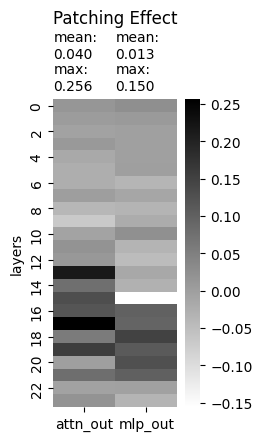

In [444]:
old_prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
new_prompt = ["Harry Potter absolutely hates Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
#new_prompt = ["Harry absolutely loves Ron. The relationship between Harry Potter and Ronald Weasley is"]
#new_prompt = ["The relationship between Demorats and Republicans is"]


#new_prompt = ["Democrats like Republicans. The relationship between Democrats and Republicans is"]
#new_prompt = ["The relationship between Democrats and Republicans is"]
#old_prompt = ["The relationship between Harry and Ron is"]

old_logits, old_activs = measuring.prompt_with_cache(model,old_prompt,logit_idx=scale_idx,norm=False)
new_logits, new_activs = measuring.prompt_with_cache(model,new_prompt,logit_idx=scale_idx,norm=False)

vector_scale, vector_dir = patch_activs(model, old_logits, new_logits, new_activs, old_prompt, scale_idx)
plot_heatmap(vector_scale.cpu().numpy(), cmap="binary")

In [756]:
strength_vec, dir_vec = run_patching_loop(model, context_pairs, scale_idx)

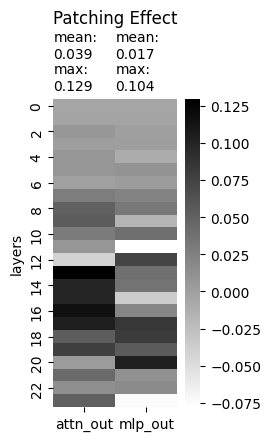

In [450]:
plot_heatmap(strength_vec.mean(0).cpu().numpy(), cmap="binary")

## Apply Patches

### Before Patching

In [551]:
prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
prompt = ["Harry Potter absolutely hates Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
prompt = ["Harry Potter loves Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]


logits, activs = measuring.prompt_with_cache(model,prompt,logit_idx=scale_idx,norm=True)
scale_v = logits[..., 0]
scale_v

tensor([0.5889], device='mps:0')

### After Patching

In [680]:
def dir_scale_patch(activs, dir_strength, alpha=1):
    
    ## how to project b onto a (where a is the scale)
    ## a / |a| * |b| * (a * b / (|a| * |b|))
    ## --> a * (a * b / |a|**2)
    
    a = activs
    b = dir_strength 
    
    ab_a_norm = torch.einsum("...vd,...vd->...v", a, b) / (torch.norm(a, dim=-1) ** 2)
    b_to_a = a * ((ab_a_norm * alpha) + 1)
    return b_to_a


def control_hook_point(activs, hook: HookPoint, dir_strength, alpha): 
    
    i = int(hook.layer())
    j = {"hook_attn_out":0, "hook_mlp_out":1}[hook.name.split(".")[2]]
    
    patched_activs = dir_scale_patch(activs[...,-1,:], dir_strength[...,i,j,:], alpha=alpha)
    activs[...,-1,:] = patched_activs

    
def control_bias_context(model, prompt, dir_strength, alpha=1.0):
    
    patch_hook_fn = partial(control_hook_point, dir_strength=dir_strength, alpha=alpha)   
    patch_layers_fn = [(lambda name: name.endswith("attn_out") or name.endswith("mlp_out"), patch_hook_fn)]
    
    patch_logits = model.run_with_hooks(prompt, fwd_hooks=patch_layers_fn, return_type="logits", reset_hooks_end=True)
    return patch_logits

In [780]:
def prepare_dir_strength(dir_vec, strength_vec):
    
    dir_vec_diff = dir_vec[:,1]
    dir_vec_diff = torch.einsum("...nlcd,...nlc->...nlcd", dir_vec_diff, torch.norm(dir_vec_diff, dim=-1))
    dir_strength = torch.einsum("...nlcd,...nlc->...nlcd", dir_vec_diff, strength_vec)
    dir_strength = dir_strength.mean(0).unsqueeze(0) ## shape: 1lcd
    return dir_strength


dir_strength = prepare_dir_strength(dir_vec, strength_vec)
context_patch_logits = control_bias_context(model, prompt, dir_strength, alpha=1)

context_patch_logits = measuring.select_logits(context_patch_logits[:,-1,:], scale_idx, norm=True)
context_scale_v = context_patch_logits[..., 0]
context_scale_v

tensor(0.6595, device='mps:0')

In [773]:
dir_vec.shape

torch.Size([20, 2, 24, 2, 1024])

In [897]:
X = dir_vec[:,:,0,0,:].view(-1, 1024).cpu().numpy()
y = np.concatenate((np.ones(20),np.ones(20)*(-1)))

In [926]:
import numpy as np

class LDA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            SW += (X_c - mean_c).T.dot((X_c - mean_c))
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)

        # Determine SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.linear_discriminants = eigenvectors[0:self.n_components]

    def transform(self, X):
        # project data
        return np.dot(X, self.linear_discriminants.T)
    
lda = LDA(n_components=1024)
lda.fit(X,y)
lda.linear_discriminants

array([[ 3.38195276e-02+0.j        , -4.00444330e-02+0.j        ,
         2.84454657e-02+0.j        , ...,  2.19604602e-02+0.j        ,
        -4.24051775e-02+0.j        ,  1.24676597e-02+0.j        ],
       [-3.27316582e-02+0.j        ,  2.89827718e-02+0.j        ,
        -2.41506764e-02+0.j        , ..., -2.40518628e-02+0.j        ,
         3.62313704e-02+0.j        , -9.43417683e-03+0.j        ],
       [ 2.43961882e-02-0.00457319j, -1.58520369e-02+0.03297757j,
         1.24729923e-02-0.00963353j, ...,  4.18550357e-02+0.0080609j ,
        -1.14028657e-02+0.01093588j,  8.64938686e-04-0.01126414j],
       ...,
       [-1.02860014e-03+0.j        , -1.44067323e-03+0.j        ,
         3.14521967e-04+0.j        , ..., -1.51172596e-04+0.j        ,
        -6.20134730e-03+0.j        ,  1.14271186e-04+0.j        ],
       [-5.11977890e-03+0.j        , -2.79846856e-04+0.j        ,
        -3.84248250e-04+0.j        , ..., -1.12466774e-03+0.j        ,
        -1.46345335e-03+0.j        

In [978]:
import matplotlib as mpl
import seaborn as sns

import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from measureLM import helpers

from sklearn.decomposition import PCA

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


x_trans = np.dot(X, lda_eigenvT)
fig, (ax) = plt.subplots(1, figsize=(5, 5), gridspec_kw={'hspace': 0.40})
ax.scatter(x_trans[:, 0], x_trans[:, 1], c=y)
#ax.scatter(x_trans[:, 0], np.zeros(x_trans.shape[0]), c=y)
plt.show()


NameError: name 'lda_eigenvT' is not defined

In [948]:
np.dot(x_trans, inv.T)

array([[-0.04125595-1.33248731e-13j,  0.02831177-1.19280221e-13j,
         0.00154072-8.53849004e-14j, ..., -0.03406756-9.94451991e-15j,
         0.01566811-7.80464171e-15j,  0.03321961-1.10925435e-14j],
       [-0.03522902-1.39839467e-13j,  0.01603128-1.21495089e-13j,
        -0.01494496-8.11651609e-14j, ..., -0.03296367-1.11595990e-14j,
         0.02301764-7.90691418e-15j,  0.01346659-1.20813082e-14j],
       [-0.04402159-1.32106818e-13j,  0.0230327 -1.16933545e-13j,
        -0.00877209-8.53603898e-14j, ..., -0.04134224-1.03438882e-14j,
         0.00834452-7.47500219e-15j,  0.03452327-1.04497158e-14j],
       ...,
       [-0.04095849-1.40738291e-13j,  0.01998618-1.14018953e-13j,
        -0.02714976-8.28956240e-14j, ..., -0.05403065-9.64513213e-15j,
         0.01159578-7.13735569e-15j,  0.0093191 -1.24972215e-14j],
       [-0.06371282-1.32966089e-13j,  0.02562979-1.06371474e-13j,
        -0.02322412-8.06192474e-14j, ..., -0.07723141-7.59274025e-15j,
        -0.0093632 -8.18136728e-15j

In [949]:
inv = np.linalg.inv(lda.linear_discriminants)

In [879]:
X[0] = X[0].reshape(1, -1) + (lda.linear_discriminants * 0.5)

/var/folders/tb/fh7d_tg94q9_80kfqt4p54rc0000gn/T/ipykernel_38942/3414659427.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  X[0] = X[0].reshape(1, -1) + (lda.linear_discriminants * 0.5)


In [944]:
X_projected = np.dot(X, lda.linear_discriminants.T)

X_projected

array([[-0.00625163+0.j        ,  0.00580439+0.j        ,
         0.00309225+0.01584751j, ..., -0.02006477+0.j        ,
         0.01867186+0.j        , -0.04046271+0.j        ],
       [-0.00625161+0.j        ,  0.00580437+0.j        ,
         0.00309226+0.01584752j, ...,  0.00145414+0.j        ,
         0.00913084+0.j        , -0.05442508+0.j        ],
       [-0.00625159+0.j        ,  0.00580435+0.j        ,
         0.00309227+0.01584753j, ..., -0.01147132+0.j        ,
         0.02299748+0.j        , -0.05008493+0.j        ],
       ...,
       [-0.00729751+0.j        ,  0.00580437+0.j        ,
         0.00309226+0.01584752j, ...,  0.00718446+0.j        ,
         0.0127489 +0.j        , -0.05401258+0.j        ],
       [-0.00729747+0.j        ,  0.00580433+0.j        ,
         0.00309225+0.01584751j, ..., -0.00451238+0.j        ,
         0.02077458+0.j        , -0.05775377+0.j        ],
       [-0.00729751+0.j        ,  0.00580437+0.j        ,
         0.00309226+0.01584752

In [920]:
X_projected = np.dot(X, forward_lda.T)
np.dot(X_projected, forward_lda.T)

array([[ 2.15565656e-02-0.01221877j, -2.03506383e-02+0.00898814j,
        -2.39241419e-03-0.00485946j, ...,  1.24209783e-02-0.00912531j,
         3.80233142e-04+0.01292977j, -1.24123784e-02+0.00437746j],
       [ 2.13093285e-02-0.01142534j, -2.02426197e-02+0.00823672j,
        -1.92603223e-03-0.00417156j, ...,  1.26541722e-02-0.00954831j,
         3.69587180e-04+0.01299098j, -1.24022772e-02+0.00444658j],
       [ 2.20564764e-02-0.01204614j, -2.09130136e-02+0.00890315j,
        -1.30728153e-03-0.00466486j, ...,  1.23885610e-02-0.00948421j,
         3.74245375e-04+0.0129744j , -1.24166490e-02+0.00443293j],
       ...,
       [ 2.00217392e-02-0.01081168j, -1.88342220e-02+0.00776201j,
        -2.27504739e-03-0.00520592j, ...,  1.50787217e-02-0.01037517j,
         7.38649420e-05+0.01310708j, -1.27245847e-02+0.00457103j],
       [ 2.16788407e-02-0.01064734j, -2.04162543e-02+0.00776148j,
        -1.11677344e-03-0.00521966j, ...,  1.55804112e-02-0.01120321j,
         4.34144241e-05+0.01321354j

In [922]:
X

array([[-0.04125595,  0.02831177,  0.00154072, ..., -0.03406756,
         0.01566811,  0.03321961],
       [-0.03522902,  0.01603128, -0.01494496, ..., -0.03296367,
         0.02301764,  0.01346659],
       [-0.04402159,  0.0230327 , -0.00877209, ..., -0.04134224,
         0.00834452,  0.03452327],
       ...,
       [-0.04095849,  0.01998618, -0.02714976, ..., -0.05403065,
         0.01159578,  0.0093191 ],
       [-0.06371282,  0.02562979, -0.02322412, ..., -0.07723141,
        -0.0093632 ,  0.03672499],
       [-0.04095849,  0.01998618, -0.02714976, ..., -0.05403065,
         0.01159578,  0.0093191 ]], dtype=float32)

In [1044]:
def lda(x1, x2, top_k=1024, device="cpu"):
    with torch.no_grad():
        x1 = torch.tensor(x1, device=device, dtype=torch.float)
        x2 = torch.tensor(x2, device=device, dtype=torch.float)

        m1 = torch.mean(x1, dim=0)
        m2 = torch.mean(x2, dim=0)
        m = (len(x1) * m1 + len(x2) * m2) / (len(x1) + len(x2))

        d1 = x1 - m1[None, :]
        scatter1 = d1.t() @ d1
        d2 = x2 - m2[None, :]
        scatter2 = d2.t() @ d2
        within_class_scatter = scatter1 + scatter2

        d1 = m1 - m[None, :]
        scatter1 = len(x1) * (d1.t() @ d1)
        d2 = m2 - m[None, :]
        scatter2 = len(x2) * (d2.t() @ d2)
        between_class_scatter = scatter1 + scatter2

        p = torch.pinverse(within_class_scatter) @ between_class_scatter
        eigenvalues, eigenvectors = torch.linalg.eig(p)
        eigenvalues = torch.view_as_real(eigenvalues)[:,0]
        idx = torch.argsort(eigenvalues, descending=True)
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[idx, :].T
        eigenvectors = eigenvectors[:top_k, :]
        eigenvectors = torch.view_as_real(eigenvectors)[...,0]
        eigenvectors_inverse = torch.linalg.inv(eigenvectors)

        return eigenvectors.numpy(), eigenvectors_inverse.numpy()
    
    
x_1 = dir_vec[:,0,0,0,:].view(-1, 1024).cpu()
x_2 = dir_vec[:,1,0,0,:].view(-1, 1024).cpu()

eigenv, eigenv_inv = lda(x_1, x_2)

/var/folders/tb/fh7d_tg94q9_80kfqt4p54rc0000gn/T/ipykernel_38942/2366242210.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, device=device, dtype=torch.float)
/var/folders/tb/fh7d_tg94q9_80kfqt4p54rc0000gn/T/ipykernel_38942/2366242210.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2, device=device, dtype=torch.float)


_LinAlgError: linalg.inv: The diagonal element 602 is zero, the inversion could not be completed because the input matrix is singular.

In [1041]:
a = np.dot(X, eigenv.T)
np.dot(a, eigenv_inv.T)

array([[ 5.9901190e+24, -7.4279888e+26, -1.2679170e+27, ...,
        -4.4400000e+02,  4.4400000e+02,  3.3203855e-02],
       [ 7.3605593e+26, -8.1034968e+26, -9.8370059e+26, ...,
        -8.3200000e+02,  8.4000000e+02,  1.3453305e-02],
       [-9.4396048e+25, -3.0942646e+26, -1.1302349e+27, ...,
        -6.4400000e+02,  6.6400000e+02,  3.4510285e-02],
       ...,
       [ 3.9558788e+26, -3.8807393e+26, -4.8365400e+26, ...,
        -3.1800000e+02,  3.2200000e+02,  9.3299150e-03],
       [-3.4745996e+26,  6.5714838e+25, -7.4293406e+26, ...,
         4.0000000e+00,  1.6000000e+01,  3.6740832e-02],
       [ 3.9558788e+26, -3.8807393e+26, -4.8365400e+26, ...,
        -3.1800000e+02,  3.2200000e+02,  9.3299150e-03]], dtype=float32)

In [1029]:
print(x_1)
x_1_proj = torch.einsum("...nd, ...db->nb", x_1, eigenv)
x_1_back = torch.einsum("...nd, ...db->nd", x_1_proj, eigenv_inv)

x_1_back

tensor([[-0.0413,  0.0283,  0.0015,  ..., -0.0341,  0.0157,  0.0332],
        [-0.0440,  0.0230, -0.0088,  ..., -0.0413,  0.0083,  0.0345],
        [-0.0032,  0.0112, -0.0316,  ..., -0.0506, -0.0096, -0.0327],
        ...,
        [-0.0436,  0.0413, -0.0070,  ..., -0.0320, -0.0128,  0.0484],
        [-0.0601,  0.0308, -0.0138,  ..., -0.0708, -0.0016,  0.0344],
        [-0.0637,  0.0256, -0.0232,  ..., -0.0772, -0.0094,  0.0367]])


tensor([[-8.1003e+26,  1.8664e+27,  1.7737e+27,  ..., -2.0339e+08,
          2.0339e+08, -5.5600e-01],
        [-1.4473e+27,  2.8076e+27,  9.0753e+26,  ..., -2.0064e+08,
          2.0064e+08, -3.3552e-01],
        [ 1.0807e+26, -2.1907e+26,  6.6261e+26,  ..., -4.9176e+07,
          4.9176e+07, -1.1480e-01],
        ...,
        [ 2.5985e+25, -2.9188e+26,  3.2314e+26,  ...,  1.0441e+08,
         -1.0441e+08,  1.2523e+00],
        [ 4.8746e+26, -3.0732e+27,  2.7394e+27,  ...,  5.5284e+07,
         -5.5284e+07,  2.2121e-01],
        [-8.0512e+25, -2.1571e+27,  1.8758e+27,  ...,  5.1384e+07,
         -5.1384e+07,  4.1226e-01]])

In [1040]:
X

tensor([[-0.0413,  0.0283,  0.0015,  ..., -0.0341,  0.0157,  0.0332],
        [-0.0352,  0.0160, -0.0149,  ..., -0.0330,  0.0230,  0.0135],
        [-0.0440,  0.0230, -0.0088,  ..., -0.0413,  0.0083,  0.0345],
        ...,
        [-0.0410,  0.0200, -0.0271,  ..., -0.0540,  0.0116,  0.0093],
        [-0.0637,  0.0256, -0.0232,  ..., -0.0772, -0.0094,  0.0367],
        [-0.0410,  0.0200, -0.0271,  ..., -0.0540,  0.0116,  0.0093]])